In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [27]:
data_dir = "../vechicles/train/"

In [28]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 8817 files belonging to 15 classes.
Using 7054 files for training.


In [29]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 8817 files belonging to 15 classes.
Using 1763 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['beige', 'black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'tan', 'white', 'yellow']


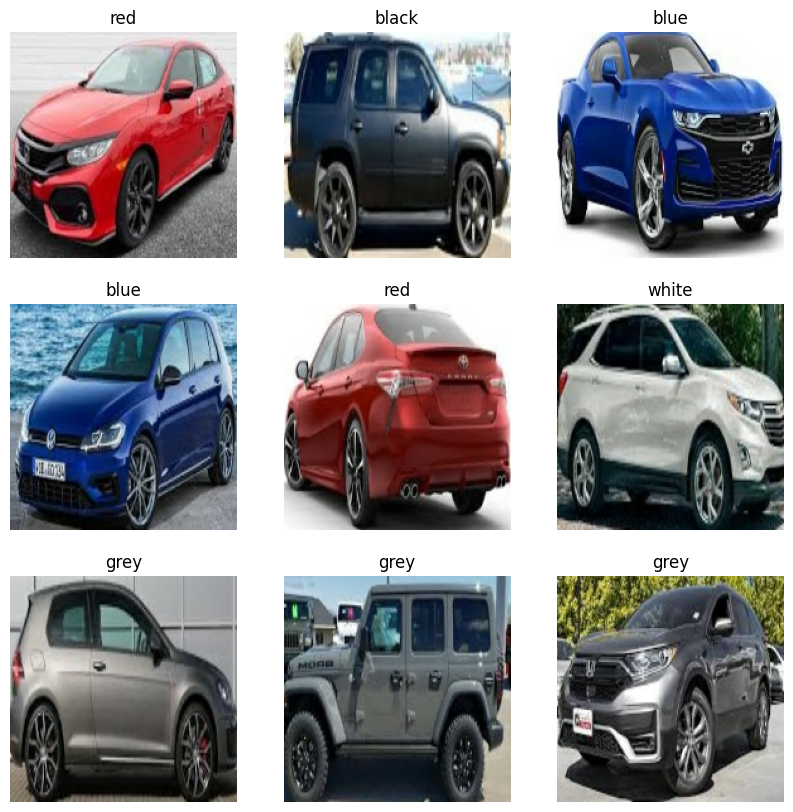

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [36]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - accuracy: 0.4020 - loss: 1.7597 - val_accuracy: 0.6489 - val_loss: 0.9445
Epoch 2/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 54s 245ms/step - accuracy: 0.7155 - loss: 0.8120 - val_accuracy: 0.7260 - val_loss: 0.7502
Epoch 3/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - accuracy: 0.7516 - loss: 0.6854 - val_accuracy: 0.7391 - val_loss: 0.7239
Epoch 4/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 52s 237ms/step - accuracy: 0.7580 - loss: 0.6666 - val_accuracy: 0.7561 - val_loss: 0.7088
Epoch 5/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 232ms/step - accuracy: 0.7789 - loss: 0.6166 - val_accuracy: 0.7964 - val_loss: 0.5880
Epoch 6/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - accuracy: 0.7764 - loss: 0.6134 - val_accuracy: 0.7623 - val_loss: 0.6931
Epoch 7/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - accuracy: 0.8060 - loss: 0.5419 - val_accuracy: 0.7873 - val_loss: 0.6266
Epoch 8/17
221/221 ━━━━━━━━━━━━━━━━━━━━ 51s 232ms/step - accuracy: 0.8156 - loss: 0

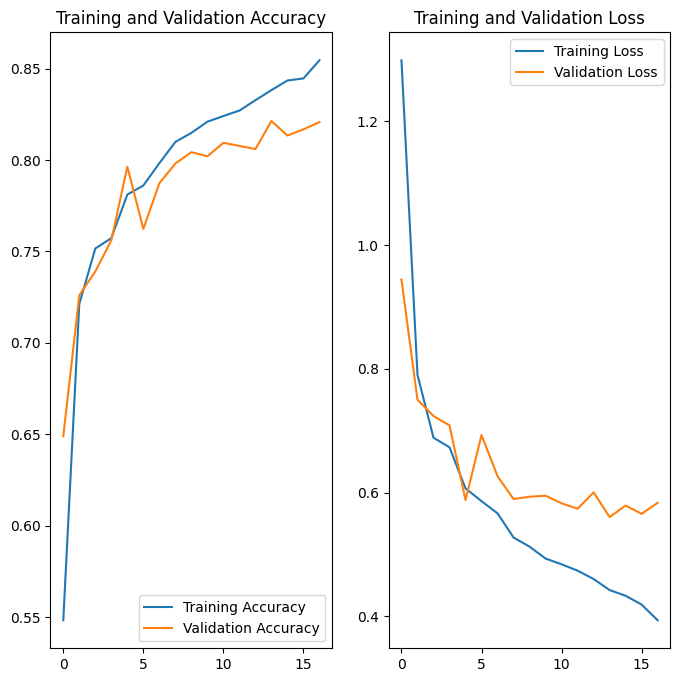

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


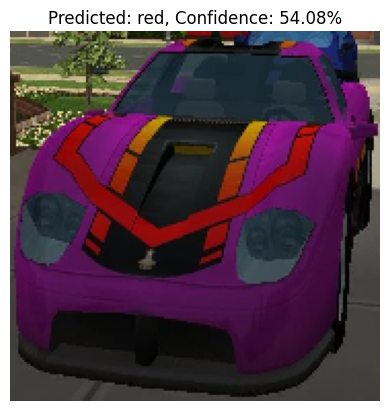

In [40]:
vechicle_path = "../vechicles/test/images.jpg"
img = tf.keras.utils.load_img(
    vechicle_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class = class_names[np.argmax(score)]

plt.figure()
plt.imshow(img)
plt.title("Predicted: {}, Confidence: {:.2f}%".format(predicted_class, 100 * np.max(score)))
plt.axis("off")
plt.show()

In [41]:
model.save("vechicles_colors_detection_17.keras")